# Исследование объявлений о продаже квартир

В этом проекте мы будем производить исследовательский анализ данных сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет.

### Загрузка данных

In [1]:
#ипортируем необходимые библиотеки
import pandas as pd
import random
import matplotlib.pyplot as plt
#данные в исходном файле разделены знаками табуляции - установим этот символ в параметр метода при чтении файла
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
#изучим информацию о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Построим гистограммы для всего датафрейма

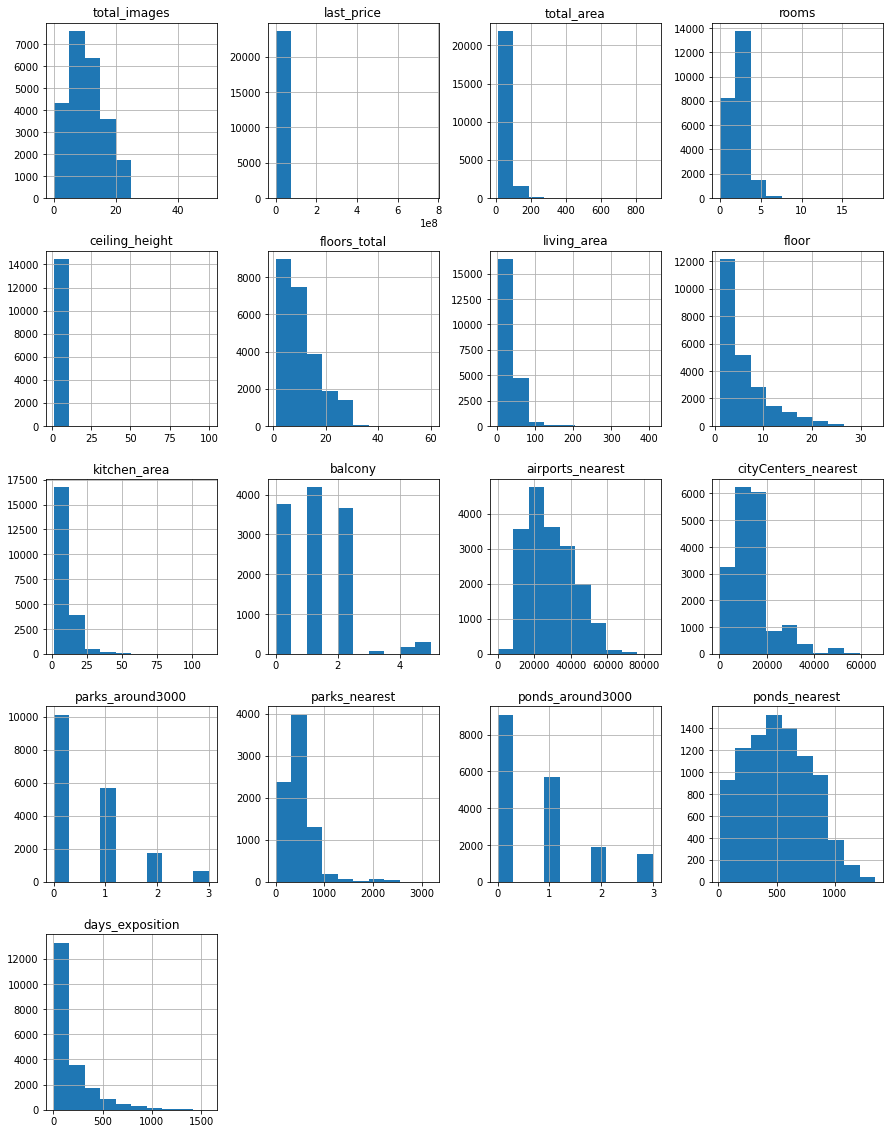

In [2]:
data.hist(figsize=(15, 20))
plt.show()

In [3]:
#проверим наличие дубликатов в данных
data.duplicated().sum()

0

In [4]:
#посчитаем количество пропусков
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

**Обзор данных**

Данные содержат много пропусков, вызванных в основной своей массе человеческим фактором - отсутствие информации в момент заполнения объявления, невнимательность, личное понимание важности этой информации для продажи квартиры. 
Пропуски в поле days_exposition скорее всего вызваны технической ошибкой, поскольку эти данные формируются системой.

Также есть некорректные типы данных:
* floors_total, balcony, parks_around3000, ponds_around3000 - заменим на целое число, поскольку эти данные по своей природе не могут быть дробными
* is_apartment - заменим на булев тип, потому что характер данных предполагает использование этого типа
* last_price, airports_nearest, cityCenters_nearest, parks_nearest, ponds_nearest, days_exposition - заменим на целое число, поскольку в контексте единиц измерения этих характеристик большая точность нам для анализа не понадобится

Явных дубликатов в данных не обнаружено

### Предобработка данных

Достаточно много пропусков в данных о высоте потолков, которые с высокой вероятностью вызваны отсутствием информации у владельца. Поскольку высота потолков достаточно стандартизированная величина, привязанная к типам проектов квартир, целесообразно заполнить ее средним значением по выборке. Тем более, что существенных выбросов в этих данных не отмечается. 

In [5]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

In [6]:
#изучим какие мы можем выделить типы строений по этажности
data['floors_total'].unique()

array([16., 11.,  5., 14., 12., 26., 24., 27.,  9.,  6., 17., 25.,  3.,
       23., 19., 18.,  4., 22.,  8.,  2., 10.,  7., 13., 15., nan, 20.,
       28., 36., 21., 35., 34., 60.,  1., 29., 33., 52., 37.])

В данных об этажности много шумов, поэтому на данном этапе пока заполним пропуски нулевыми значениями и обработаем их на этапе исследовательского анализа данных.

In [7]:
data['floors_total'] = data['floors_total'].fillna(0)

В данных о жилой площади имеются пропуски в порядка 10% записей. Эта характеристика также является объективной, и можно ее заполнить путем вычисления недостающих данных.

In [8]:
#вычислим соотношение жилой площади к общей в заполненных данных
data['area_ratio'] = data['living_area'] / data['total_area']
#заполним пропуски средним значением этого соотношения
data['area_ratio'] = data['area_ratio'].fillna(data['area_ratio'].mean())
#вычислим жилую площать для записей с пропусками этого значения и заполним ее в них
data['living_area'] = data['living_area'].fillna(data['total_area'] * data['area_ratio'])

Схожая ситуация наблюдается с указанием площади кухни. Разница только в том, что площадь кухни не увеличивается пропорционально площади всего помещения - кухни как правило имеют типовые размеры. Поэтому заполним эти пропуски медианным значением. 

In [9]:
data['rooms'].unique()

array([ 3,  1,  2,  4,  5,  6,  0,  7, 11,  8, 14, 10, 15,  9, 19, 16, 12])

In [10]:
#Заполним пропуски в площади кухни медианным значением площади кухни в квартирах с разным количеством комнат
#для этого сначала заполним нулями пропуски в указании площади кухни для студий
data.loc[data['rooms'] == 0, 'kitchen_area'] = data.loc[data['rooms'] == 0, 'kitchen_area'].fillna(0)
#заменим пропущенные значения в цикле
for flat_type in data['rooms'].unique():
        data.loc[(data['rooms'] == flat_type) & (data['kitchen_area'].isna()), 'kitchen_area'] = \
        data.loc[data['rooms'] == flat_type, 'kitchen_area'].median()
#проверим результат
data['kitchen_area'].isna().sum()

0

Поле is_apartment очевидно обозначает принадлежность объекта к типу помещения "квартира". Пропусков в этом поле огромное количество, и вызваны они с высокой вероятностью человеческим фактором - кладельцы квартир судя по всему не посчитали необходимым констатировать очевидное. Заполним это поле автоматически, следуя логике его предназначения.

In [11]:
#заполним False пропуски в столбце is_apartment для записей, которые обозначены как studio или open_plan
data['is_apartment'] = data.query('(studio == True) | (open_plan == True)')['is_apartment'].fillna(False)
#заполним True все остальные пропуски
data['is_apartment'] = data['is_apartment'].fillna(True)

Пропуски в данных по количеству балконов целесообразно заполнить нулевым значением, поскольку забыть о такой значимой характеристике достаточно сложно, и отсутствие данных скорее всего обозначает отсутствие балкона. Вычисление же этой характеристики может только исказить статистику данных.

In [12]:
data['balcony'] = data['balcony'].fillna(0)

Пропуски в указании местонахождения также невозможно заполнить вычислениями, поэтому заполним их значениями по-умолчанию:

In [13]:
data['locality_name'] = data['locality_name'].fillna('Не указан')

Пропуски в данных об удаленности от центра города и аэропортов стоит заполнить медианным значением, поскольку все объекты должны этой характеристикой обладать, и она не указана скорее всего по усмотрению пользователя как несущественная, что в свою очередь говорит о том, что по факту эти показатели у объекта среднестатистические. 

In [14]:
data['airports_nearest'] = data['airports_nearest'].fillna(data['airports_nearest'].median())
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(data['cityCenters_nearest'].median())

Пропуски в данных о расстоянии до парков и водоемов стоит оставить, поскольку эта информация очевидно должна влиять на цену объекта, пропусков этих очень много, и их заполнение существенным образом исказит статистику - не будем их заполнять.

Пропуски в полях parks_around3000 и ponds_around3000 могут вызваны ошибкой пользователя, которую можно проверить по наличию данных в полях parks_nearest и ponds_nearest. При отсутствии же этих ошибок, пропуски в колонках parks_around3000 и ponds_around3000 можно заполнить нулями, следуя вышеизложенной логике.

In [15]:
#проверим есть ли ошибки при заполнении полей parks_around3000 и ponds_around3000
display(data.query('0 < parks_nearest <= 3000')['parks_around3000'].isna().sum())
data.query('0 < ponds_nearest <= 3000')['ponds_around3000'].isna().sum()

0

0

In [16]:
#заполним нулями пропуски в колонках parks_around3000 и ponds_around3000
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

Пропуски в поле days_exposition скорее всего вызваны технической ошибкой. Проверим можно ли вычислить это поле на базе имеющихся данных в столбце first_day_exposition

In [17]:
data[~data['days_exposition'].isna()][['first_day_exposition', 'days_exposition']].head(10)

,first_day_exposition,days_exposition
1,2018-12-04T00:00:00,81.0
2,2015-08-20T00:00:00,558.0
3,2015-07-24T00:00:00,424.0
4,2018-06-19T00:00:00,121.0
5,2018-09-10T00:00:00,55.0
6,2017-11-02T00:00:00,155.0
8,2018-05-23T00:00:00,189.0
9,2017-02-26T00:00:00,289.0
10,2017-11-16T00:00:00,137.0
11,2018-08-27T00:00:00,7.0


Четкая зависимость от даты публикации в расчете значения days_exposition не прослеживается.
В связи с этим заполнить пропуски способом вычисления не удастся.
Это значение является значимым показателем для статистики продаж, но количество пропусков чуть больше 10%, и нам потребуется в дальнейшем анализировать этот показатель, поэтому заполним эти пропуски медианным значением.

In [19]:
#проверим результаты
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest            0
cityCenters_nearest         0
parks_around3000            0
parks_nearest           15620
ponds_around3000            0
ponds_nearest           14589
days_exposition          3181
area_ratio                  0
dtype: int64

**Приведем в порядок типы данных**
- is_apartment - заменим на булев тип
- floors_total, balcony, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition - заменим на целые числа

In [20]:
#приведем данные к правильным типам
data['is_apartment'] = data['is_apartment'].astype('bool')
for column in [
    'floors_total',
    'balcony',
    'airports_nearest',
    'cityCenters_nearest',
    'parks_around3000',
    'last_price',
    'ponds_around3000',
#    'days_exposition'
]:
    data[column] = data[column].astype('int32')

In [21]:
#проверим результаты
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  int32  
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23699 non-null  int32  
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23699 non-null  float64
 13  balcony               23699 non-null  int32  
 14  locality_name         23699 non-null  object 
 15  airports_nearest   

In [22]:
#очистим названия населенных пунктов в столбце locality_name от прочей информации и поместим в отдельный столбец
data['locality_id'] = data['locality_name'].replace(
    ['посёлок ',
     'деревня ',
     'городской ',
     'садовое товарищество ',
     'городского типа ',
     'поселок ',
     'садоводческое некоммерческое товарищество ',
     'при железнодорожной станции ',
     'станции ',
     'село ',
     'коттеджный ',
     'имени ',
    ], '', regex=True
)
#проверим результат
data['locality_id'].sort_values().unique()

array(['Агалатово', 'Александровская', 'Алексеевка', 'Аннино', 'Аро',
       'Барышево', 'Батово', 'Бегуницы', 'Белогорка', 'Белоостров',
       'Бокситогорск', 'Большая Вруда', 'Большая Ижора',
       'Большая Пустомержа', 'Большие Колпаны', 'Большое Рейзино',
       'Большой Сабск', 'Бор', 'Борисова Грива', 'Бугры', 'Будогощь',
       'Ваганово', 'Важины', 'Вартемяги', 'Вахнова Кара', 'Вещево',
       'Виллози', 'Вознесенье', 'Возрождение', 'Войсковицы', 'Войскорово',
       'Володарское', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Вырица', 'Выскатка', 'Высокоключевой', 'Высоцк', 'Гаврилово',
       'Гарболово', 'Гатчина', 'Гладкое', 'Глажево', 'Глебычево',
       'Глинка', 'Гончарово', 'Горбунки', 'Гостилицы', 'Громово',
       'Дзержинского', 'Дружная Горка', 'Дружноселье', 'Дубровка',
       'Елизаветино', 'Ефимовский', 'Жилгородок', 'Жилпосёлок', 'Житково',
       'Заводской', 'Заклинье', 'Заневка', 'Запорожское', 'Зеленогорск',
       'Зимитицы', 'Ивангород', 'Извара'

In [23]:
#также проверим на сколько количество уникальных названий населенных пунктов после устранения дубликатов
print('Количество названий населенных пунктов уменьшилось на',
      len(data['locality_name'].unique()) - len(data['locality_id'].unique()),
      'единиц, что составляет {:.0%}'
      .format((len(data['locality_name'].unique()) - len(data['locality_id'].unique())) / len(data['locality_name'].unique())),
      'от изначального числа записей.'
     )

Количество названий населенных пунктов уменьшилось на 59 единиц, что составляет 16% от изначального числа записей.


**Результаты предобработки данных**

В процессе предобработки данных были устранены пропуски в полях:
- ceiling_height           9195
- floors_total               86
- living_area              1903
- is_apartment            20924
- kitchen_area             2278
- balcony                 11519
- locality_name              49
- airports_nearest         5542
- cityCenters_nearest      5519
- parks_around3000         5518
- ponds_around3000         5518

В целях предотвращения искажения статистики продаж, решено оставить пропуски в следующих полях: 
- parks_nearest           15620
- ponds_nearest           14589



Также были устранены неявные дубликаты в названиях населенных пунктов в количестве 59 записей, в результате чего количество уникальных названий сократилось на 16% от изначального количества.

### Добавление вычисляемых данных

In [24]:
#вычислим в отдельном столбце цену за квадратный метр и округлим ее до целого числа
data['unit_price'] = round(data['last_price'] / data['total_area']).astype('int')
#проверим результат
data[['last_price', 'total_area', 'unit_price']].head()

,last_price,total_area,unit_price
0,13000000,108.0,120370
1,3350000,40.4,82921
2,5196000,56.0,92786
3,64900000,159.0,408176
4,10000000,100.0,100000


In [25]:
#выведем в новом столбце информацию о дне недели даты публикации
data['exposition_weekday'] = pd.DatetimeIndex(data['first_day_exposition']).weekday
#проверим результат
data[['first_day_exposition', 'exposition_weekday']].head()

,first_day_exposition,exposition_weekday
0,2019-03-07T00:00:00,3
1,2018-12-04T00:00:00,1
2,2015-08-20T00:00:00,3
3,2015-07-24T00:00:00,4
4,2018-06-19T00:00:00,1


In [26]:
#выведем в новом столбце информацию о месяце даты публикации
data['exposition_month'] = pd.DatetimeIndex(data['first_day_exposition']).month
#проверим результат
data[['first_day_exposition', 'exposition_month']].head()

,first_day_exposition,exposition_month
0,2019-03-07T00:00:00,3
1,2018-12-04T00:00:00,12
2,2015-08-20T00:00:00,8
3,2015-07-24T00:00:00,7
4,2018-06-19T00:00:00,6


In [27]:
#выведем в новом столбце информацию о годе даты публикации
data['exposition_year'] = pd.DatetimeIndex(data['first_day_exposition']).year
#проверим результат
data[['first_day_exposition', 'exposition_year']].head()

,first_day_exposition,exposition_year
0,2019-03-07T00:00:00,2019
1,2018-12-04T00:00:00,2018
2,2015-08-20T00:00:00,2015
3,2015-07-24T00:00:00,2015
4,2018-06-19T00:00:00,2018


In [28]:
#составим функцию для категоризации этажа
def detect_floor(row):
    flat_floor = row['floor']
    building_height = row['floors_total']
    try:
        if flat_floor == 1:
            return 'первый'
        elif flat_floor == building_height:
            return 'последний'
        else:
            return 'другой'
    except:
        return 'ошибка данных'
#создадим столбец с категориями этажей, применив эту функцию к датасету
data['floor_category'] = data.apply(detect_floor, axis=1)
#проверим результат
data[['floor', 'floors_total', 'floor_category']].head()

,floor,floors_total,floor_category
0,8,16,другой
1,1,11,первый
2,4,5,другой
3,9,14,другой
4,13,14,другой


In [29]:
#добавим расстояние до центра в километрах и округлим до двух знаков после запятой
data['km_2_center'] = round(data['cityCenters_nearest'] / 1000).astype('int')
#проверим результат
data[['cityCenters_nearest', 'km_2_center']].head()

,cityCenters_nearest,km_2_center
0,16028,16
1,18603,19
2,13933,14
3,6800,7
4,8098,8


### Исследовательский анализ данных

In [30]:
#создадим функцию для контроля нормы остатка изначальных данных при очистке от выбросов
def drop_control(master, replica):
    drop_rate = (len(master) - len(replica)) / len(master)
    print('Операциями выбросов удалено {:.0%}'
          .format(drop_rate),
          'изначальных данных. \n' ,
          )
    if drop_rate <= 0.1:
        print('Состояние базы в норме.')
    else:
        print('Внимание - превышена норма очистки данных.')  

In [31]:
#Изучим числовое описание данных об общей площади помещений
data['total_area'].describe()

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

Как видно из числового описания, максимальное значение находится далеко за пределами характерного разброса.
Для корректной визуализации данных стоит убрать выбросы, находящиеся за верхним пределом ящика с усами.
Межквартильный размах составляет почти 30 единиц, полуторное его значение - 45. Соответственно, край правого "уса" приходится на значение 115 м2.
Уберем выбросы свыше этого значения.

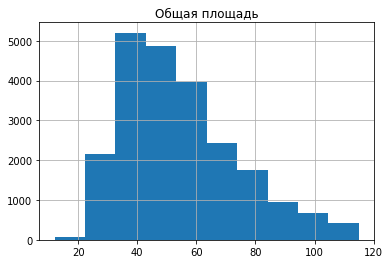

In [32]:
#создадим новый датасет из записей, значение площади помещения которых находится в пределах до 115 кв.м. 
clean_data = data.query('total_area <= 115')
#построим гистограмму по новым данным
clean_data['total_area'].hist(bins=10)
plt.title('Общая площадь')
plt.show()

In [33]:
#Проверим норму очистки данных
drop_control(data, clean_data)

Операциями выбросов удалено 5% изначальных данных. 

Состояние базы в норме.


In [34]:
#Изучим числовое описание данных о жилой площади помещений в очищенном датасете
clean_data['living_area'].describe()

count    22482.000000
mean        31.090978
std         13.384777
min          2.000000
25%         18.600000
50%         29.700000
75%         40.000000
max        101.000000
Name: living_area, dtype: float64

В этих данных мы видим аналогичный выброс, который целесообразно обрезать до верхней границы характерного разброса:
Верхняя граница характерного разброса составит 40 + 22 * 1,5 = 73 кв.м.
Оставим в наборе данных помещения с жилой площадью до 75 кв.м. включительно

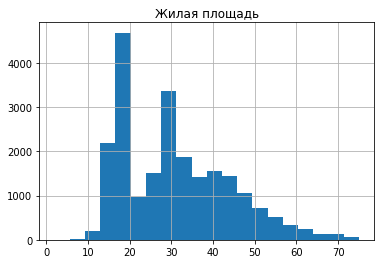

In [35]:
#обновим датасет, убрав из него значения жилой площади за пределами верхнего выброса
clean_data = clean_data.query('living_area <= 75')
#построим гистограмму по новым данным
clean_data['living_area'].hist(bins=20)
plt.title('Жилая площадь')
plt.show()

In [36]:
#Проверим норму очистки данных
drop_control(data, clean_data)

Операциями выбросов удалено 6% изначальных данных. 

Состояние базы в норме.


In [37]:
#Изучим числовое описание данных о площади кухни
clean_data['kitchen_area'].describe()

count    22393.000000
mean         9.753580
std          4.252416
min          0.000000
25%          7.000000
50%          9.000000
75%         11.000000
max         60.000000
Name: kitchen_area, dtype: float64

Квартира с кухней на 60 метров - это уже ресторан :) - устраним эти выбросы тоже.

Верхняя граница характерного разброса составит 11 + (11-7) * 1,5 = 17 кв.м. 

Оставим в наборе данных помещения с площадью кухни до 20 кв.м. включительно

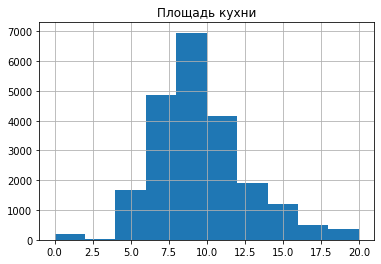

In [38]:
#обновим датасет, убрав из него значения площади кухни за пределами верхнего выброса
clean_data = clean_data.query('kitchen_area <= 20')
#построим гистограмму по новым данным
clean_data['kitchen_area'].hist(bins=10)
plt.title('Площадь кухни')
plt.show()

In [39]:
#Проверим норму очистки данных
drop_control(data, clean_data)

Операциями выбросов удалено 8% изначальных данных. 

Состояние базы в норме.


In [40]:
#Приведем данные о ценах к меньшей размерности
clean_data['last_price'] = clean_data['last_price'] / 1000
#Изучим числовое описание данных о ценах
clean_data['last_price'].describe()

count    21835.000000
mean      5134.259838
std       3085.022998
min        430.000000
25%       3315.770500
50%       4450.000000
75%       6100.000000
max      53000.000000
Name: last_price, dtype: float64

В данных о ценах мы также видим выбросы, которые имеет смысл устранить.
Верхняя граница характерного разброса составит 3300 + (6100 - 3300) * 1,5 = 7500
По нормам статистики, следует удалить объекты со стоимостью свыше 10 млн. рублей.

Однако, удалив эти данные, мы урежем выборку более чем на 10%, что не рекомендуется лучшими практиками.
К тому же, высокая стоимость наврядли является ошибкой, и даже квартира стоимостью 53 млн рублей не выглядит чем-то сверхъестесственным для этого региона.
Поэтому оставим все эти данные и используем остаток нормы обрезки для очистки других отклонений.

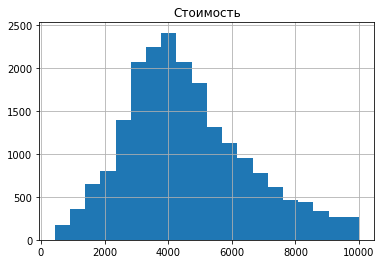

In [41]:
#построим гистограмму по стоимости объектов, устранив выбросы срезом данных
clean_data.query('last_price <= 10000')['last_price'].hist(bins=20)
plt.title('Стоимость')
plt.show()

In [42]:
#Проверим норму очистки данных
drop_control(data, clean_data)

Операциями выбросов удалено 8% изначальных данных. 

Состояние базы в норме.


In [43]:
#Изучим числовое описание данных о количестве комнат
clean_data['rooms'].describe()

count    21835.000000
mean         1.933868
std          0.895586
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: rooms, dtype: float64

Наши люди в спальню на велисипеде не ездят :)
Верхняя граница характерного разброса составит 3 + (3-1) * 1,5 = 6
Получается, бывает что и ездят) 

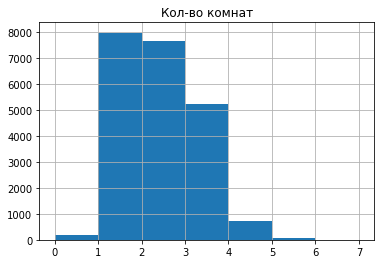

In [44]:
#построим гистограмму по данным о количестве комнат
clean_data['rooms'].hist(bins=7)
plt.title('Кол-во комнат')
plt.show()

In [45]:
#Изучим числовое описание данных о высоте потолков
clean_data['ceiling_height'].describe()

count    21835.000000
mean         2.705417
std          1.021143
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

I feel happy - like a room without a roof =)

Эти данные надо дополнительно очистить от ошибок.
Посмотрим какие уникальные значения имеются в этих записях. 

In [46]:
#Проверим уникальные значения на наличие опечаток
clean_data['ceiling_height'].unique()

array([  2.65,   2.5 ,   2.67,   2.56,   3.05,   2.7 ,   2.75,   2.6 ,
         2.9 ,   2.8 ,   2.55,   3.  ,   2.61,   3.2 ,   3.25,   3.45,
         2.77,   2.64,   2.57,   4.15,   4.  ,   2.47,   2.73,   2.84,
         3.1 ,   2.34,   3.4 ,   3.06,   2.72,   2.54,   2.51,   2.78,
         2.76,  25.  ,   2.58,   2.52,   3.5 ,   2.87,   2.66,   2.59,
         2.  ,   2.85,   3.3 ,   2.45,   2.92,   3.13,   3.8 ,   3.15,
         3.55,   3.62,   3.12,   2.53,   2.96,   2.46,   5.  ,   2.79,
         2.95,   4.06,   2.94,   3.7 ,   3.54,   2.74,   2.83,   2.4 ,
         3.38,   3.01,   3.65,   2.71,   2.3 ,   2.48,   2.62,   3.57,
         2.82,   3.98,   2.63,   3.83,   3.75,   2.88,   4.19,   3.35,
         3.24,   4.8 ,   4.5 ,   4.2 ,  32.  ,   3.07,   3.37,   3.09,
         8.  ,   3.16,   3.6 ,   3.34,   2.81,   3.44,   4.37,   3.9 ,
         3.27,  27.  ,   4.1 ,   3.95,   2.68,   3.46,  24.  ,   3.47,
         3.33,   3.63,   3.14,   3.32,   3.52,  26.  ,   1.2 ,   3.18,
      

In [47]:
#Заменим опечатки на разумные значения
clean_data.loc[clean_data['ceiling_height'] > 15, 'ceiling_height'] /= 10
#проверим результат
clean_data['ceiling_height'].sort_values().unique()

array([ 1.  ,  1.2 ,  1.75,  2.  ,  2.2 ,  2.25,  2.26,  2.3 ,  2.34,
        2.4 ,  2.45,  2.46,  2.47,  2.48,  2.49,  2.5 ,  2.51,  2.52,
        2.53,  2.54,  2.55,  2.56,  2.57,  2.58,  2.59,  2.6 ,  2.61,
        2.62,  2.63,  2.64,  2.65,  2.66,  2.67,  2.68,  2.69,  2.7 ,
        2.71,  2.72,  2.73,  2.74,  2.75,  2.76,  2.77,  2.78,  2.79,
        2.8 ,  2.81,  2.82,  2.83,  2.84,  2.85,  2.86,  2.87,  2.88,
        2.89,  2.9 ,  2.91,  2.92,  2.93,  2.94,  2.95,  2.96,  2.97,
        2.98,  2.99,  3.  ,  3.01,  3.02,  3.03,  3.04,  3.05,  3.06,
        3.07,  3.08,  3.09,  3.1 ,  3.11,  3.12,  3.13,  3.14,  3.15,
        3.16,  3.17,  3.18,  3.2 ,  3.21,  3.22,  3.23,  3.24,  3.25,
        3.26,  3.27,  3.28,  3.3 ,  3.31,  3.32,  3.33,  3.34,  3.35,
        3.36,  3.37,  3.38,  3.39,  3.4 ,  3.42,  3.44,  3.45,  3.46,
        3.47,  3.48,  3.49,  3.5 ,  3.52,  3.53,  3.54,  3.55,  3.56,
        3.57,  3.59,  3.6 ,  3.62,  3.63,  3.65,  3.66,  3.67,  3.7 ,
        3.75,  3.78,

In [48]:
#Снова изучим числовое описание данных
clean_data['ceiling_height'].describe()

count    21835.000000
mean         2.677591
std          0.226025
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         14.000000
Name: ceiling_height, dtype: float64

Непонятно, что имели ввиду люди, указывая высоту потолков в 14 метров - будем расценивать эти данные как выбросы, наравне с потолками ниже 2.4 метров.
Граница характерного разброса находится на уровне 3 метров, при этом нам известно, что в домах дореволюционной постройки могут быть потолки и по 6 метров. Поэтому уберем из датасета только совсем нереальстичные значения.

<AxesSubplot:>

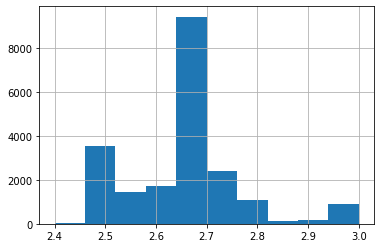

In [49]:
#обновим датасет, убрав из него значения высоты потолков за пределами верхнего и нижнего выбросов
clean_data = clean_data.query('2.4 <= ceiling_height <= 6')
#построим гистограмму по новым данным, убирая выбросы срезом
clean_data.query('ceiling_height <= 3')['ceiling_height'].hist(bins=10)

In [50]:
#Проверим норму очистки данных
drop_control(data, clean_data)

Операциями выбросов удалено 8% изначальных данных. 

Состояние базы в норме.


<AxesSubplot:>

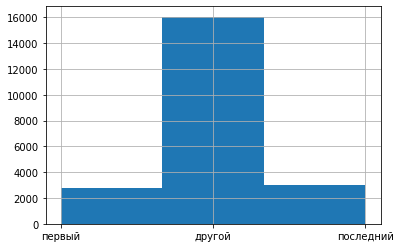

In [51]:
#строим гистограмму по категориям этажности
clean_data['floor_category'].hist(bins=3)

In [52]:
#выведем уникальные значения этажности зданий и количество объектов
clean_data.groupby('floors_total')['floors_total'].count()

floors_total
0       78
1       22
2      356
3      592
4     1023
5     5400
6      657
7      448
8      301
9     3668
10    1099
11     181
12    1283
13     203
14     529
15     332
16    1268
17     792
18     475
19     314
20     232
21     148
22     274
23     334
24     448
25    1020
26     120
27     162
28      21
29       1
34       1
35      18
36       3
52       1
60       1
Name: floors_total, dtype: int64

Можно предположить, что единичные указания этажности здания вызваны ошибкой пользователя и на самом деле этажность здания соответствует соседней с большим количеством записей. Этажность 60 скорее всего имеет лишний ноль.
Перед заменой значений проверим какие значения этажа указаны в объявлениях, чтобы не создать искусственную ошибку.

In [53]:
clean_data[['floor', 'floors_total']].query('(floors_total >= 29) & (floors_total != 35)')

,floor,floors_total
397,28,36
1697,23,34
2253,4,60
3797,18,29
5807,13,36
11079,29,36
16731,18,52


In [54]:
#заменим некорректные значения
clean_data['floors_total'] = clean_data['floors_total'].astype('str')
clean_data['floors_total'] = clean_data['floors_total'].replace('36', '35')
clean_data['floors_total'] = clean_data['floors_total'].replace('34', '35')
clean_data['floors_total'] = clean_data['floors_total'].replace('60', '6')
clean_data['floors_total'] = clean_data['floors_total'].replace('29', '28')
clean_data['floors_total'] = clean_data['floors_total'].replace('52', '25')
clean_data['floors_total'] = clean_data['floors_total'].astype('int')
#проверим результат
clean_data['floors_total'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 35])

Теперь заполним данные о пропусках в данных об этажности здания, которые мы заполнили нулевыми значениями на этапе предобработки данных. Для заполнения их корректными данными нам надо выяснить, какие значения указаны пользователем в поле Этаж: 

In [55]:
clean_data[['floor', 'floors_total']].query('floors_total == 0')

,floor,floors_total
186,4,0
237,1,0
457,12,0
671,8,0
1757,9,0
...,...,...
21651,19,0
21753,21,0
22542,3,0
22656,20,0


Поскольку у нас нет никаких других зацепок для определения этажности, кроме значения этажа в объявлении, и во избежание искажения данных о категориях этажности объектов, заполним эти пропуски случайными значениями этажности из имеющихся данных, которые превышают указанное в объявлении значение этажа.

<AxesSubplot:>

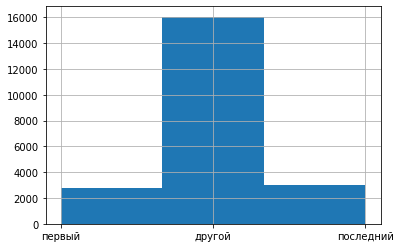

In [56]:
#строим гистограмму по категориям этажности
clean_data['floor_category'].hist(bins=3)

In [57]:
#заменим в цикле данные для строк с нулевым значением этажности на случайные из допустимого диапазона
for row in clean_data.query('floors_total == 0').index:
    floor = clean_data.loc[row, 'floor']
    clean_data.loc[row, 'floors_total'] = random.choice(
        clean_data.query('floors_total > @floor')['floors_total'].unique()
    )
    #проконтролируем работу процедуры
    print(clean_data.loc[row, ['floor', 'floors_total']])

floor            4
floors_total    18
Name: 186, dtype: object
floor            1
floors_total    20
Name: 237, dtype: object
floor           12
floors_total    25
Name: 457, dtype: object
floor            8
floors_total    35
Name: 671, dtype: object
floor            9
floors_total    14
Name: 1757, dtype: object
floor            4
floors_total    18
Name: 1930, dtype: object
floor           22
floors_total    24
Name: 2392, dtype: object
floor           15
floors_total    17
Name: 2846, dtype: object
floor            6
floors_total    20
Name: 2952, dtype: object
floor           12
floors_total    23
Name: 3031, dtype: object
floor           12
floors_total    26
Name: 3438, dtype: object
floor            1
floors_total    19
Name: 3817, dtype: object
floor            7
floors_total    17
Name: 3831, dtype: object
floor           3
floors_total    5
Name: 4140, dtype: object
floor           12
floors_total    28
Name: 4617, dtype: object
floor           18
floors_total    27
Name: 48

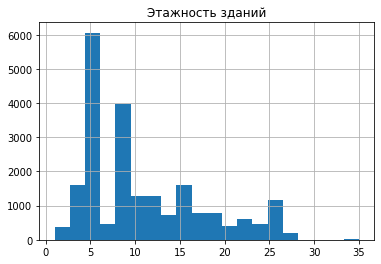

In [58]:
#построим диаграмму по обновленным данным об этажности зданий
clean_data['floors_total'].hist(bins=20)
plt.title('Этажность зданий')
plt.show()

array([[<AxesSubplot:title={'center':'cityCenters_nearest'}>]],
      dtype=object)

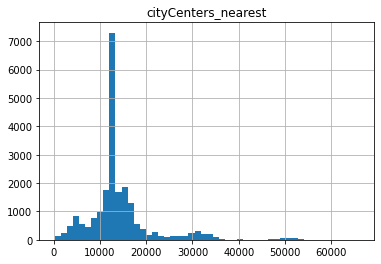

In [59]:
#построим диаграмму расстояния до центра города в метрах
clean_data.hist('cityCenters_nearest', bins=50)

Очевидно наличие выбросов в данных, но в данном случае убирать их по правилам статистики будет неправильным, поскольку это не ошибки, а рельный данные об объектах, находящихся за пределами городской черты - мы помним типы населенных пнктов село, деревня, ж/д станция. 
Поэтому в данном случем просто нормализуем эти данные, приведя их к ближайшему достаточно часто повторящемуся значению, например 50000 м, небольшой всплеск вокруг которого мы видим на гистограмме.

In [60]:
#Создадим функцию, которая заменит значения выше указанного порога
def normalize(dist):
    threshold = 50000
    if dist > threshold:
        return threshold
    else:
        return dist
#Применим эту функцию к столбцу с целевыми данными
clean_data['cityCenters_nearest'] = clean_data['cityCenters_nearest'].apply(normalize)

array([[<AxesSubplot:title={'center':'cityCenters_nearest'}>]],
      dtype=object)

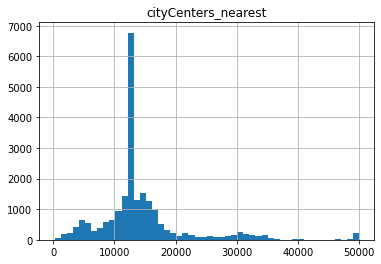

In [61]:
#построим гистограмму по нормализованным данным
clean_data.hist('cityCenters_nearest', bins=50)

<AxesSubplot:>

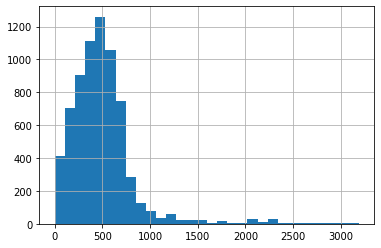

In [62]:
#построим гистограмму по расстояниям до парков
clean_data['parks_nearest'].hist(bins=30)

In [63]:
#получим описание данных
clean_data['parks_nearest'].describe()

count    6980.000000
mean      493.294986
std       339.082333
min         1.000000
25%       289.750000
50%       458.000000
75%       617.000000
max      3190.000000
Name: parks_nearest, dtype: float64

Максимальное значение далеко за пределами характерного разброса, но дальнейшая очистка данных от выбросов невозможна, поскольку мы уже удалили максимально допустимый по норме объем данных.

Поэтому в дальнейшем для целей улучшения визуализации результатов будем сужать выборку средствами срезов данных.

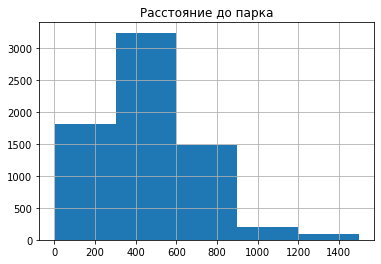

In [64]:
#построим гистограмму по срезу данных с учетом выбросов
clean_data.query('parks_nearest <= 1500')['parks_nearest'].hist(bins=5)
plt.title('Расстояние до парка')
plt.show()

<AxesSubplot:>

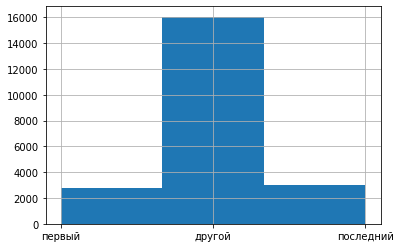

In [65]:
#строим гистограмму по категориям этажности
clean_data['floor_category'].hist(bins=3)

In [66]:
#проверим норму очистки данных
drop_control(data, clean_data)

Операциями выбросов удалено 8% изначальных данных. 

Состояние базы в норме.


**Поскольку мы последовательно корректировали данные в новом датасете, построим все гистограммы заново и проанализируем результаты:**

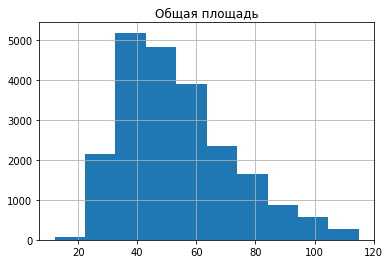

In [67]:
#Гистограмма площади помещений
clean_data['total_area'].hist(bins=10)
plt.title('Общая площадь')
plt.show()

**Распределение помещений по площади**

Анализ подтверждает общепринятое мнение, что лидерами продаж являются небольшие квартиры с площадью в районе 30-40 кв.м
Очевидно, такие квартиры популярны среди молодых семей без детей, которые регулярно продают их с целью улучшения жилищных условий при увеличении размера семьи.

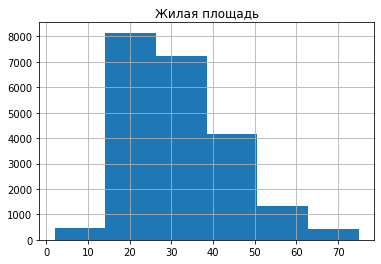

In [68]:
#Гистограмма по жилой площади помещений
clean_data['living_area'].hist(bins=6)
plt.title('Жилая площадь')
plt.show()

**Распределение помещений по жилой площади**

Тут картина вполне релевантна распределению по общей площади - однокомнатные квартиры как правило имеют жилую площадь в районе 20 м2.

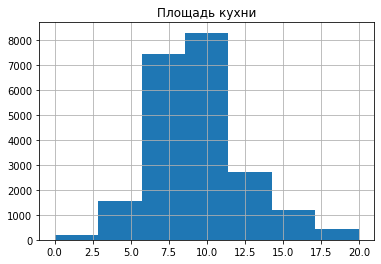

In [69]:
#Гистограмма по площади кухни
clean_data['kitchen_area'].hist(bins=7)
plt.title('Площадь кухни')
plt.show()

**Распределение помещений по площади кухни**

Здесь мы также видим близкое к нормальному распределение с пиком в районе 9 кв.м., что примерно соответствует площади кухни в однокомнатной квартире.

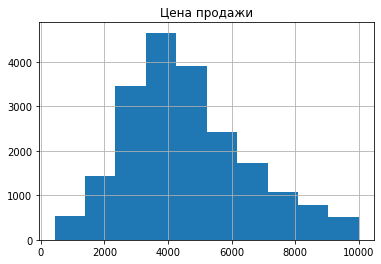

In [70]:
#Гистограмма по цене продажи
clean_data.query('last_price <= 10000')['last_price'].hist(bins=10)
plt.title('Цена продажи')
plt.show()

**Цена продажи**

Самая распространенная стоимость сделки составляет около 5 млн рублей.

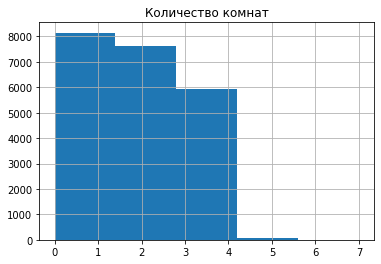

In [71]:
#Гистограмма по количеству комнат
clean_data['rooms'].hist(bins=5)
plt.title('Количество комнат')
plt.show()

**Количество комнат**

Как мы уже отмечали раньше, самая большая активность на рынке вторичной недвижимости происходит по продаже одно- и двухкомнатных квартир.

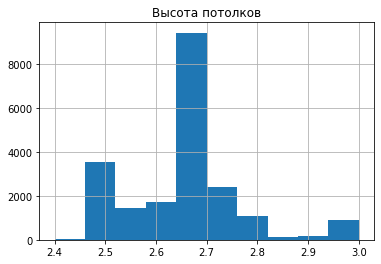

In [72]:
#Гистограмма по высоте потолков
clean_data.query('ceiling_height <= 3')['ceiling_height'].hist(bins=10)
plt.title('Высота потолков')
plt.show()

**Высота потолков**

Чаще всего в продаже фигурируют квартиры с высотой потолков 2.7 метра. При этом, видна еще одна крупная группа объектов с высотой потолков 2.5 метра - очевидно это старый жилфонд.

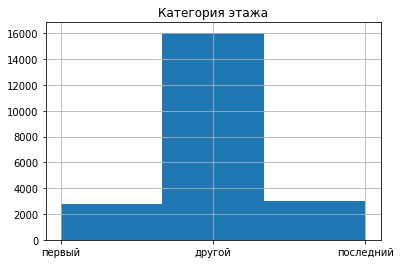

In [73]:
#Гистограмма по категориям этажности
clean_data['floor_category'].hist(bins=3)
plt.title('Категория этажа')
plt.show()

**Категории этажности**

На этой гистограмме мы видим естесственное распределение, когда основная масса объектов попадает в среднюю категорию.

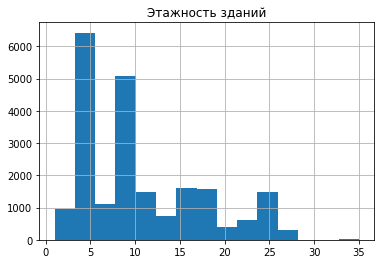

In [74]:
#Гистограмма по этажности зданий
clean_data['floors_total'].hist(bins=15)
plt.title('Этажность зданий')
plt.show()

**Этажность зданий**

Распределение объектов по этажности зданий показывает лидирующее положение 5-ти и 9-ти этажных домов.

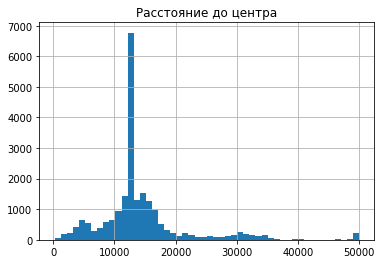

In [75]:
#Гистограмма по расстоянию до центра
clean_data.hist('cityCenters_nearest', bins=50)
plt.title('Расстояние до центра')
plt.show()

**Расстояние до центра**

Здесь мы видим, что основная масса продаваемых квартир находится на окраинах города, в спальных районах. Также в данных можно выделить три группы областных объектов - ближний пригород, область, и объекты на окраине области.

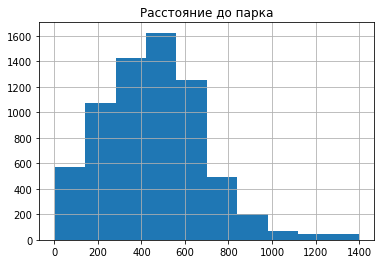

In [76]:
#Гистограмма по расстоянию до ближайших парков
clean_data.query('parks_nearest <= 1400')['parks_nearest'].hist(bins=10)
plt.title('Расстояние до парка')
plt.show()

**Расстояние до ближайшего парка**

Здесь мы видим, что в основном пользователи указыват данные о расстоянии до парков, если они находятся в радиусе полукилометра от квартиры.

**Скорость продажи квартир**
Построим гистограмму по полю days_exposition
Вычислим среднее значение и медиану
Изучим полученную информацию

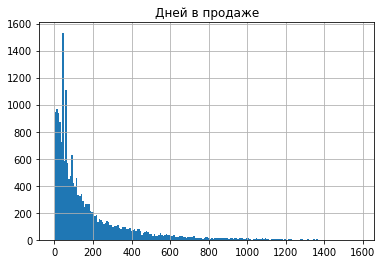

In [77]:
clean_data['days_exposition'].hist(bins=200)
plt.title('Дней в продаже')
plt.show()

In [78]:
print('Среднее значение дней нахождения в продаже:', clean_data['days_exposition'].mean())
print('Медианное значение дней нахождения в продаже:', clean_data['days_exposition'].median())

Среднее значение дней нахождения в продаже: 173.49916133766644
Медианное значение дней нахождения в продаже: 92.0


Как видно на гистограмме, основная масса квартир продается за период в пределах 200 дней. Наиболее типовой срок продажи квартиры составляет 95 дней, что отражает значение медианы. Среднее значение срока продажи в полтора раза выше медианы, и составляет 159 дней - это обусловлено существенным количеством долгих продаж, с выбросами до 1400 дней, которые мы также видим на гистограмме.

**Однако, на большой детализации корзин мы также можем наблюдать несколько выбросов в количестве повторяющихся значений, которые следует проанализировать подробнее.**

In [79]:
#изучим количество уникальных значений по полю days_exposition
clean_data.query('days_exposition < 150')['days_exposition'].value_counts().sort_values(ascending=False)

45.0     873
60.0     524
7.0      228
30.0     198
4.0      169
        ... 
149.0     31
129.0     25
148.0     12
2.0        3
1.0        1
Name: days_exposition, Length: 149, dtype: int64

По результатам количественного анализа мы видим большое количество записей с числом дней продажи, кратным календарным единицам - 7, 30, 45, 60. Можно предположить, что эти данные имеют какое-то административно-техническое происхождение.

Проверить такую гипотезу средствами анализа имеющихся данных не представляется возможным, требуется уточнение от источника выгрузки.

**Факторы, влияющие на стоимость объекта**

Построим диаграммы рассеяния для оценки зависимости значения last_price от параметров
- общей площади;
- жилой площади;
- площади кухни;
- количества комнат;
- этажа, на котором расположена квартира (первый, последний, другой);
- даты размещения (день недели, месяц, год).

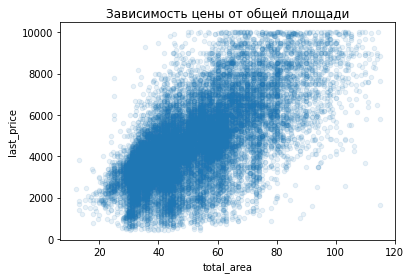

In [80]:
#построим диаграмму зависимости цены от общей площади
clean_data.query('last_price <= 10000').plot(y='last_price', x='total_area', kind='scatter', alpha=0.1)
plt.title('Зависимость цены от общей площади')
plt.show()

Как видно из диаграммы, общая цена конечно напрямую зависит от площади квартиры, но с увеличением площади эта зависимость размывается. Это говорит о том, что на стоимость больших квартир существенное влияние оказывают какие-то другие факторы.

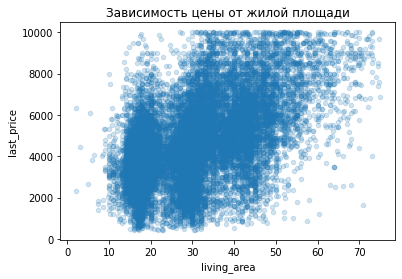

In [81]:
#построим диаграмму зависимости цены от жилой площади
clean_data.query('last_price <= 10000').plot(y='last_price', x='living_area', kind='scatter', alpha=0.2)
plt.title('Зависимость цены от жилой площади')
plt.show()

Похожую картину мы можем наблюдать на диаграмме зависимости цены от жилой площади, с еще большим размытием зависимости по мере роста жилой площади, и формированием трех групп помещений с жилой площадью в районе 20, 30 и 40 кв.м., демонстрирующих неэластичность цены по жилой площади в каждой из них. Это говорит о том, что стоимость квартиры конечно меняется от размеров жилой площади, просто из-за большего количества квадратных метров, но цена за метр для одинаковых по площади объектов будет сильно колебаться в зависимости от других факторов.

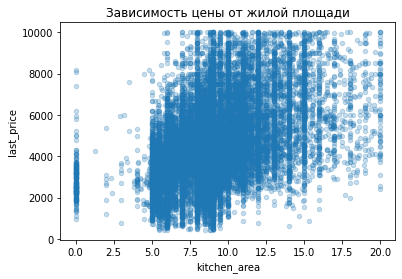

In [82]:
#построим диаграмму зависимости цены от площади кухни
clean_data.query('last_price <= 10000').plot(y='last_price', x='kitchen_area', kind='scatter', alpha=0.2)
plt.title('Зависимость цены от жилой площади')
plt.show()

Зависимость цены от площади кухни также имеется, в силу того, что квартиры с большей площадью имеют и большего размера кухни, но эта зависимсть еще слабее чем для жилой площади, а в силу дискретности данных о площади кухни мы можем также наблюдать полную неэластичность стоимости квартиры от площади кухни практически для каждого типоразмера. На основании этого можно утверждать, что площадь кухни не является определяющим фактором для определения стоимости квартиры.

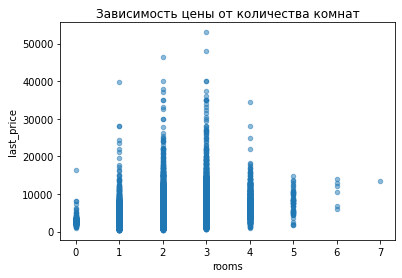

In [83]:
#построим диаграмму зависимости цены от количества комнат
clean_data.plot(y='last_price', x='rooms', kind='scatter', alpha=0.5)
plt.title('Зависимость цены от количества комнат')
plt.show()

По количеству комнат мы видим еще более яркую картину того, что на стоимость квартиры влияет множество других факторов, кроме количества комнат.

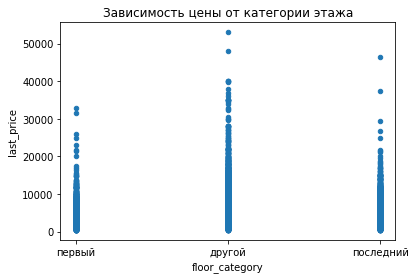

In [84]:
#построим диаграмму зависимости цены от категории этажа
clean_data.plot(y='last_price', x='floor_category', kind='scatter')
plt.title('Зависимость цены от категории этажа')
plt.show()

Совершенно смело можно сделать вывод, что категория этажа не оказывает влияния на цену квартиры.

Однако заметно, что квартиры на первом этаже никогда не попадают в высшие ценовые категории.

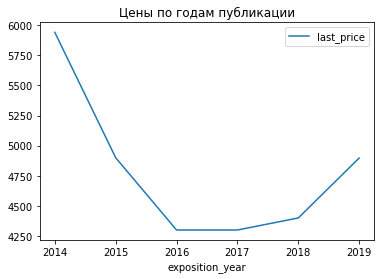

In [85]:
#построим график по сводной таблице для года публикации 
clean_data.pivot_table(
    index='exposition_year',
    values='last_price',
    aggfunc='median').plot()
plt.title('Цены по годам публикации')
plt.show()

На этом графике мы видим, что с 2014 года медианная стоимость продаваемых квартир постепенно падала вплоть до 2016-2017 годов, в течение которых на продажу выставлялись в основном дешевые квартиры. В 2018-2019 годах наблюдается тенденция к росту цены на продаваемое жилье.

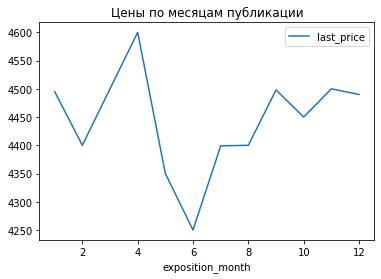

In [86]:
#построим график по сводной таблице для месяца публикации 
clean_data.pivot_table(
    index='exposition_month',
    values='last_price',
    aggfunc='median').plot()
plt.title('Цены по месяцам публикации')
plt.show()

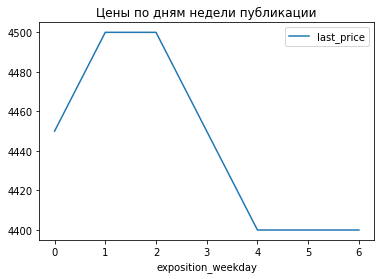

In [87]:
#построим график по сводной таблице для месяца публикации 
clean_data.pivot_table(
    index='exposition_weekday',
    values='last_price',
    aggfunc='median').plot()
plt.title('Цены по дням недели публикации')
plt.show()

Графики показывают ожидаемое отсутсвие какой-либо зависимости стоимости квартиры от месяца и дня недели публикации.

**Топ-10 населенных пунктов по продажам**

In [88]:
#Построим сводную таблицу, отсортируем ее по убыванию количества объектов, и получим верхние 10 значений
top_sales = (clean_data
             .pivot_table(index='locality_id', values='unit_price', aggfunc=['count', 'mean'])
             .sort_values(by=('count', 'unit_price'), ascending=False)
             .head(10)
            )
#переименуем колонки для лучшей читабельности
top_sales.columns = ['Кол-во объектов', 'Средняя цена']
top_sales

,Кол-во объектов,Средняя цена
locality_id,,
Санкт-Петербург,14057,109472.372981
Мурино,583,86184.847341
Кудрово,451,95633.607539
Шушары,434,78722.783410
Всеволожск,387,68564.020672
Пушкин,334,101486.781437
Колпино,332,75387.713855
Парголово,324,90296.907407
Гатчина,301,68803.382060


In [89]:
print('Максимальная средняя цена за квадратный метр составила', round(top_sales['Средняя цена'].max()), 'рублей')
print('Минимальная средняя цена за квадратный метр составила', round(top_sales['Средняя цена'].min()), 'рублей')

Максимальная средняя цена за квадратный метр составила 109472 рублей
Минимальная средняя цена за квадратный метр составила 58221 рублей


**Квартиры в Санкт-Петербурге**

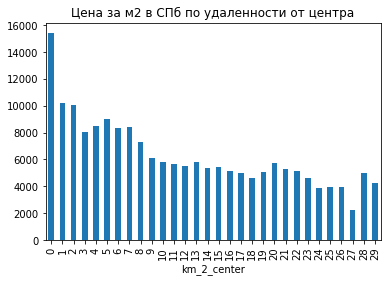

In [90]:
spb_sales = (clean_data
                 .query('locality_id == "Санкт-Петербург"')
                 .groupby('km_2_center')['last_price'].mean()
                 .plot(x='km_2_center', y='last_price', kind='bar')
                )
plt.title('Цена за м2 в СПб по удаленности от центра')
plt.show()

На графике видно, что пиковая цена за квадратный метр в Санкт-Петербурге наблюдается в центре города. Объекты на удалении даже 1 км сильно теряют в цене, и далее цена постепенно убывает по мере дальнейшего удаления от центра города. При этом на расстоянии в 28 км от центра, очевидно, находится некий элитный район, в котором эта тенденция нарушается.

### Общий вывод

По результатам анализа данных о продажах квартир в Санкт-Петербурге и Ленинградской области за 2014-2019 годы можно сделать следующие выводы:
1. Лидерами продаж являются одно-двухкомнатные квартиры общей площадью в районе 40 кв.м., жилой площалью порядка 25 кв.м., кухней на 9 кв.м. и высотой потолков 2,7 метра
2. Большинство проданных квартир расположены в 5-ти и 9-ти этажных домах, на средних этажах
3. Основная масса продаваемых квартир находится на окраинах города, в спальных районах. При этом выделяются три группы областных объектов - ближний пригород, область, и объекты на окраине области.
4. Среди квартир с указанием близости к инфраструктуре реакриации, лидерами продаж являются находящиеся в пешей доступности от таких объектов. Стоит отметить, что таких объектов чуть больше трети от всего объема имеющихся данных.

Основная масса квартир продается за период в пределах 200 дней. Наиболее типичный срок продажи квартиры составляет 92 дня.
Однако зафиксировано большое количество записей с числом дней продажи, кратным календарным единицам - 7, 30, 45, 60. Можно предположить, что эти данные имеют какое-то административно-техническое происхождение, и желательно получить уточнение от источника выгрузки данных.

Если говорить о параметрах, влияющих на стоимость квартиры, то из исследованного набора явным образом к таковым можно отнести только общую площадь помещения, и то до стоимости порядка 5 млн рублей, выше которой зависимость существенно ослабевает. Жилая площадь помещения показывает похожую зависимость.

Можно утверждать, что следующие параметры совершенно не влияют на общую стоимость квартиры:
- площадь кухни
- количество комнат
- категория этажности
- месяц и день недели публикации

На протяжении периода исследования, с 2014 года медианная стоимость продаваемых квартир постепенно падала вплоть до 2016-2017 годов, в течение которых на продажу выставлялись в основном дешевые квартиры. В 2018-2019 годах наблюдается тенденция к росту цены на продаваемое жилье.

Максимальная цена зарегистрированная цена за квадратный метр жилья составила 109472 рублей в городе Санкт-Петербург.
Минимальная цена за квадратный метр составила 58221 рублей в городе Выборг.

Цена за квадратный метр в центре Санкт-Петербурга больше чем вдвое превышает цены в других районах, которые постепенно убывают по мере удаления от центра города. При этом на расстоянии в 28 км от центра, очевидно, находится некий элитный район, в котором наблюдается рост цен за м2 относительно общей тенденции.